In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

import tools
from four_jet_network import FourJetNetwork

with open("filename.txt", 'r') as f:
    filename = f.read()

print("opening file")
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.


opening file
sorting data by tag


# Stage 1, pt classifier

- if 4th jet found, keep selection based on this method
- if not, proceed to stage 2

In [2]:
print("filtering from", len(s_table), "total events")

# filter so we get events with 3 or 4 b-jets, and 3 tags
nb34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nj4 = s_table.njets >= 4 # at least 4 jets
nt3 = s_table.nbtags==3  # 3 b-tags
events = s_table[nb34 & nt3 & nj4]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]

n_events = len(events)
print(n_events)

filtering from 777150 total events
302694


In [3]:
cutoff = 10  # np.max(events.njets)
padding_val = 0

# pad events out to 'cutoff' events
events = tools.pad(events, cutoff)
# boost/rotate
events = tools.boost_and_rotate(events)

/usr/local/lib/python3.6/dist-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!


  8%|▊         | 23997/302694 [00:00<00:01, 239969.66it/s]

302694 events are advancing to stage 2 since we didn't pick a 4th jet


100%|██████████| 302694/302694 [00:01<00:00, 229589.66it/s]


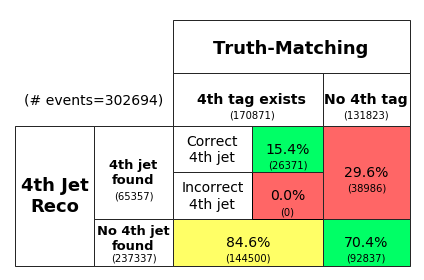

(15.43328007678307,
 0.0,
 84.56671992321694,
 29.57450520774068,
 70.42549479225931)

In [4]:
# separate the 3 first jets from the rest since they're already tagged correctly
# (given our filtering procedure above)
px_3, px_rest = events.resolved_lv.p3.x[:, :3], events.resolved_lv.p3.x[:, 3:]
py_3, py_rest = events.resolved_lv.p3.y[:, :3], events.resolved_lv.p3.y[:, 3:]
# find the best jet from _rest that fits with _3, in terms of pt sum = 0
px_3_sums = np.repeat(np.sum(px_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)
py_3_sums = np.repeat(np.sum(py_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)

px_sums = np.abs(px_rest + px_3_sums)
py_sums = np.abs(py_rest + py_3_sums)

magnitudes = np.sqrt(px_sums**2 + py_sums**2)
lowest_vals = np.min(magnitudes, axis=1)
lowest_indices = np.argmin(magnitudes, axis=1)

# lower values = more certainty
# let's set an arbitrary threshold,
# and say if lowest_val > thresh, pick no jet
thresh = 0.001
lowest_indices[lowest_vals>thresh] = cutoff-3

# also if the event was fine before adding a 4th jet, pick no jet
# this ends up having a small effect
px_sums_no_4th = np.abs(px_3_sums[:,0])
py_sums_no_4th = np.abs(py_3_sums[:,0])
magnitudes_no_4th = np.sqrt(px_sums_no_4th**2 + py_sums_no_4th**2)
lowest_indices[magnitudes_no_4th<thresh] = cutoff-3

# put this in a better format
selection_index = lowest_indices + 3
selections = np.zeros((len(events.truth), cutoff+1), dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1
# chop off last index so selection = [0,...,0] for no selection
selections = selections[:, :-1]

picked_no_4th = np.sum(selections, axis=1) == 0

print(len(picked_no_4th),
      "events are advancing to stage 2 since we didn't pick a 4th jet")

# compare to tag_u, truth_u
tools.evaluate_model(events.truth, events.tag, selections, savename='after_stage_1')

# Stage 2: The 4-jet NN Gauntlet

- make 4-jet nn
- split events into 4-jet groups
- take best-fit jet in terms of 4-jet nn results

## To make the 4-jet nn, just copy the 4b notebook

Don't worry if you see a warning about dividing by zero, fixing that!
Train on 45749 samples, validate on 6537 samples
Epoch 1/400
45749/45749 [==============================] - 3s 64us/step - loss: 0.7419 - accuracy: 0.5952 - val_loss: 0.7283 - val_accuracy: 0.5926
Epoch 2/400
45749/45749 [==============================] - 1s 31us/step - loss: 0.7173 - accuracy: 0.5931 - val_loss: 0.7080 - val_accuracy: 0.5905
Epoch 3/400
45749/45749 [==============================] - 1s 32us/step - loss: 0.7011 - accuracy: 0.5916 - val_loss: 0.6948 - val_accuracy: 0.5896
Epoch 4/400
45749/45749 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.59 - 1s 31us/step - loss: 0.6901 - accuracy: 0.5908 - val_loss: 0.6854 - val_accuracy: 0.5912
Epoch 5/400
45749/45749 [==============================] - 1s 30us/step - loss: 0.6821 - accuracy: 0.5918 - val_loss: 0.6782 - val_accuracy: 0.5919
Epoch 6/400
45749/45749 [==============================] - 1s 28us/step - loss: 0.6757 - accuracy: 

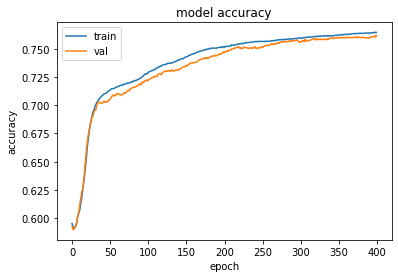

In [5]:
# filter so we get events with 4 jets, 3 or 4 b-jets, and 3 tags
j4 = (s_table.njets == 4) # 4 jets
b34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nt3 = s_table.nbtags==3  # 3 b-tags
events_4j = s_table[j4 & b34 & nt3]
events_4j = events_4j[events_4j.truth[:,0] == 1]
events_4j = events_4j[events_4j.truth[:,1] == 1]
events_4j = events_4j[events_4j.truth[:,2] == 1]
# pad, boost, rotate
events_4j = tools.pad(events_4j, length=4)
events_4j = tools.boost_and_rotate(events_4j)
# create network
nn = FourJetNetwork(events_4j)
nn.learn()
#nn.evaluate()

In [6]:
# the network score for some events is given by
def score(nn, evs):
    """Note: this expects evs to be events of 4 jets"""
    nn_input = tools.scale_nn_input(evs)
    nn_score = nn.model.predict(nn_input)
    return nn_score.flatten()

1661359
Train on 1162951 samples, validate on 166137 samples
Epoch 1/300
1162951/1162951 [==============================] - 33s 29us/step - loss: 0.3941 - accuracy: 0.8507 - val_loss: 0.6010 - val_accuracy: 0.7481
Epoch 2/300
1162951/1162951 [==============================] - 34s 29us/step - loss: 0.2395 - accuracy: 0.9121 - val_loss: 0.5480 - val_accuracy: 0.7499
Epoch 3/300
1162951/1162951 [==============================] - 34s 29us/step - loss: 0.2141 - accuracy: 0.9140 - val_loss: 0.5201 - val_accuracy: 0.7575
Epoch 4/300
1162951/1162951 [==============================] - 34s 29us/step - loss: 0.2027 - accuracy: 0.9151 - val_loss: 0.5052 - val_accuracy: 0.7606
Epoch 5/300
1162951/1162951 [==============================] - 34s 29us/step - loss: 0.1965 - accuracy: 0.9161 - val_loss: 0.4955 - val_accuracy: 0.7634
Epoch 6/300
1162951/1162951 [==============================] - 33s 29us/step - loss: 0.1923 - accuracy: 0.9171 - val_loss: 0.4876 - val_accuracy: 0.7664
Epoch 7/300
1162951/1

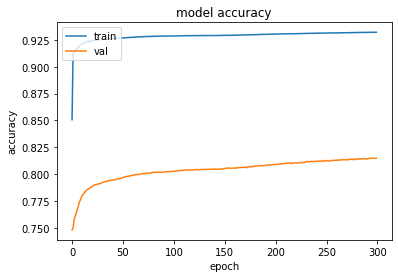

In [7]:
scores = np.zeros((len(events), cutoff), dtype=float)

# each group has this size
group_len = len(events.truth[picked_no_4th])

group_events = awkward.Table()
group_events.truth = np.concatenate([events.truth[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.tag = np.concatenate([events.tag[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
pt = np.concatenate([events.resolved_lv.pt[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
eta = np.concatenate([events.resolved_lv.eta[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
phi = np.concatenate([events.resolved_lv.phi[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
E = np.concatenate([events.resolved_lv.E[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.resolved_lv = urm.TLorentzVectorArray.from_ptetaphie(
    pt, eta, phi, E)
print(len(group_events.truth))
group_nn = FourJetNetwork(group_events)
group_nn.learn(epochs=300)
#group_nn.evaluate()

In [8]:
group_scores = score(group_nn, group_events)
print(group_scores.shape)
group_scores = group_scores.reshape((group_len, cutoff-3))

(1661359,)


In [9]:
maxes = np.max(group_scores, axis=1)
select = np.argmax(group_scores,axis=1)
select[maxes < 0.5] = cutoff
nn_selections = np.zeros((len(select), cutoff+1), dtype=int)
for i, s in enumerate(select):
    nn_selections[i][s] = 1

# chop off the last "no selection" jet
nn_selections = nn_selections[:,:-1]

# and actually evaluate
#tools.evaluate_model(events.truth[picked_no_4th], events.tag[picked_no_4th], nn_selections)

100%|██████████| 302694/302694 [00:02<00:00, 114196.34it/s]


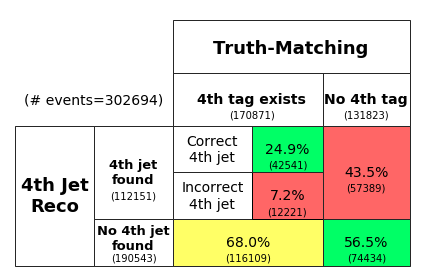

(24.896559392758277,
 7.152179129284666,
 67.95126147795706,
 43.534891483276816,
 56.46510851672318)

In [10]:
# edit the selections from earlier
selections[picked_no_4th] = nn_selections
tools.evaluate_model(events.truth, events.tag, selections, savename="after_stage_2")